<a href="https://colab.research.google.com/github/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_11_foregrounds_and_ILC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)
!python -c "import pixell" || python -m pip install pixell
!python -c "import pysm3" || python -m pip install pysm3

In [ ]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width

pix_size = cs.pix_size

# The structure of this notebook

- First we will briefly overview the need for and types of component separation methods 
- Next we will discuss a simple model for simulating dust and synchroton and examine their spectral behaviour
- Next will will develop a template based foreground cleaning method
- Finally we will develop a simple ILC method to isolate the CMB E and B mode polarization in simple simulations



# A quick introduction

So far we have largely considered observations of the sky at a single frequency. Unfortunately for us as CMB scientists the mm sky is composed of many sources, both galactic and extra galactic in origin, that obscure the CMB anisotropies. (Of course, these contributions are very interesting to study as signals in their own right, however today we will limit our discussion to treating these as contaminants). 


Fortunately these other signals, hereafter foregrounds, have different spectral and spatial properties to the CMB anistropies. The spectral properties of the key Galatic signals can be seen in Figure 1),
### Figure 1)

<div>
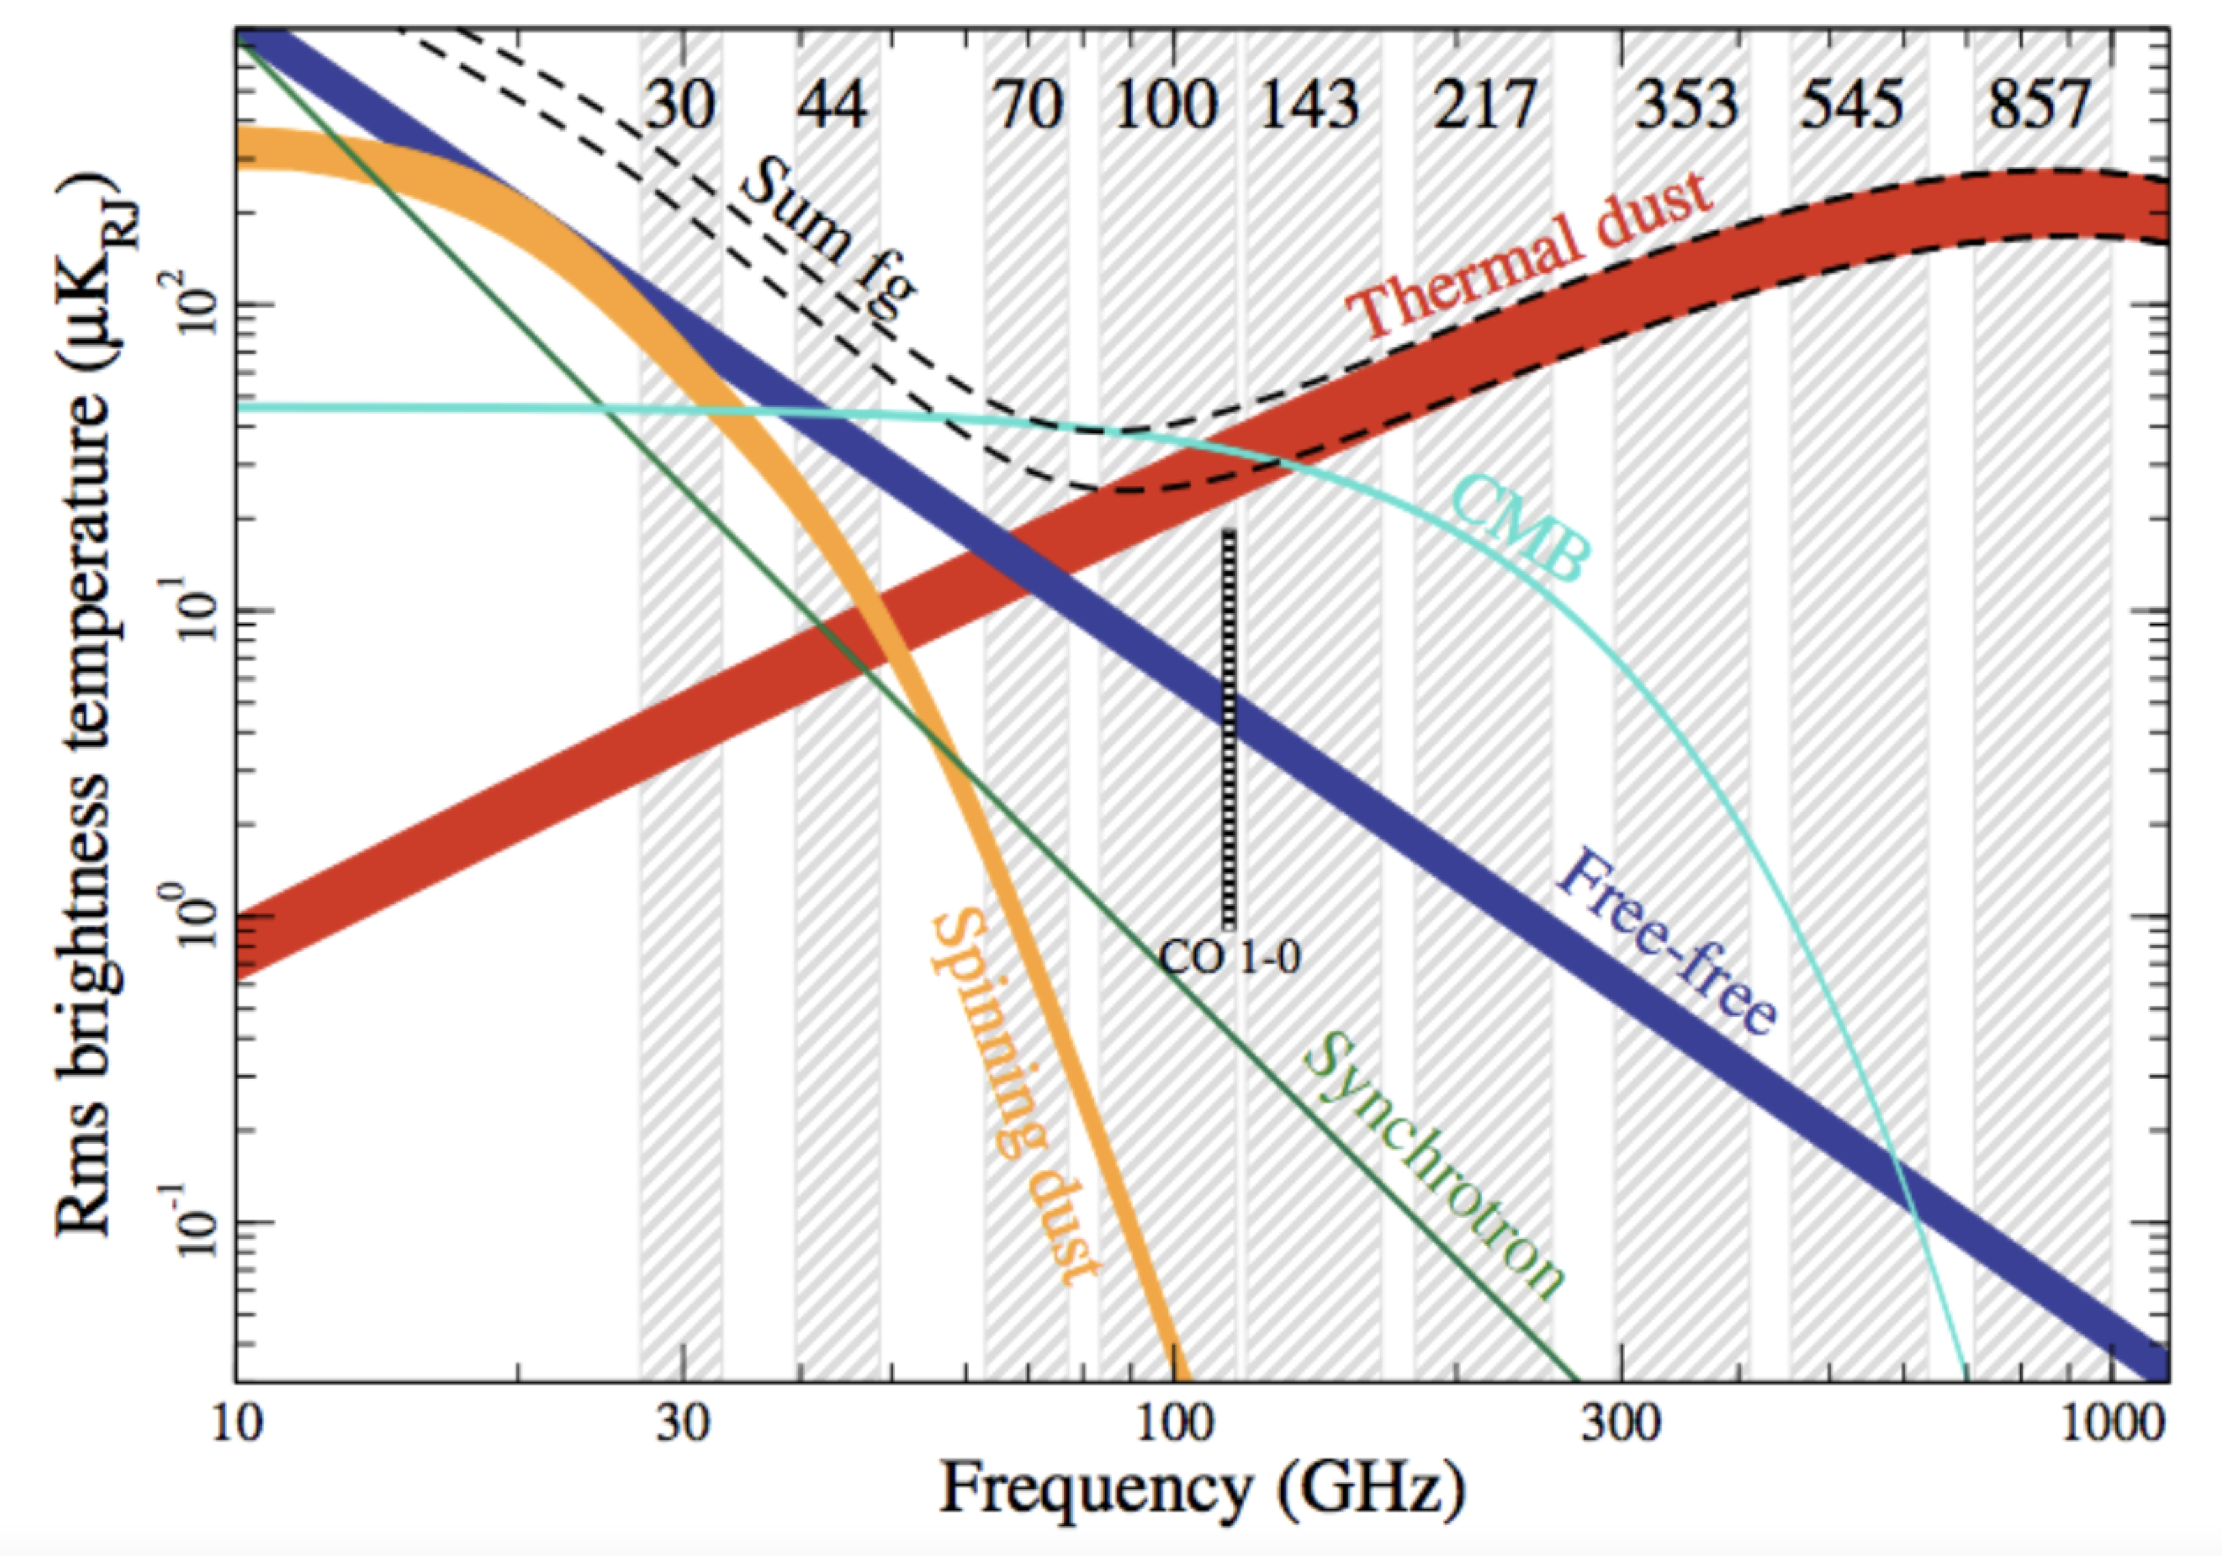
</div>
 Source Dickinson et al (2016) - which is a nice quick overview of the Galatic contributions to the mm sky (1606.03606)


We see that even if we observe the sky around 70 GHz in temperature, where the CMB is the dominant sky signal, the Galatic signals are not negligible (and neither are the extra-galactic sources).  Thus for any analysis of CMB  anisotropies we need to understand and/or remove these signals. 

Foreground mitigation techniques can be broadly grouped into two classes that we will call non-blind and blind approaches. In non-blind methods, we typically assume a parametric form for the spectral, and potentially spatial, properties of the foregrounds. Given this model and a likelihood (almost always a Gaussian likelihood) fit for the properties of the foreground model and the CMB. We can then use a maximum likelihood approach or sampling based approach (see the likelihood and MCMC notebooks) to recover the CMB. This approach has been extensively used in the CMB community to marginalize over the contributions from small scale extra-galactic foregrounds. Thus when you see plots of the CMB temperature power spectra, eg Figure 2, you are likely seeing the results of a non-blind/ parametric componenent separation method:

### Figure 2)

<div>
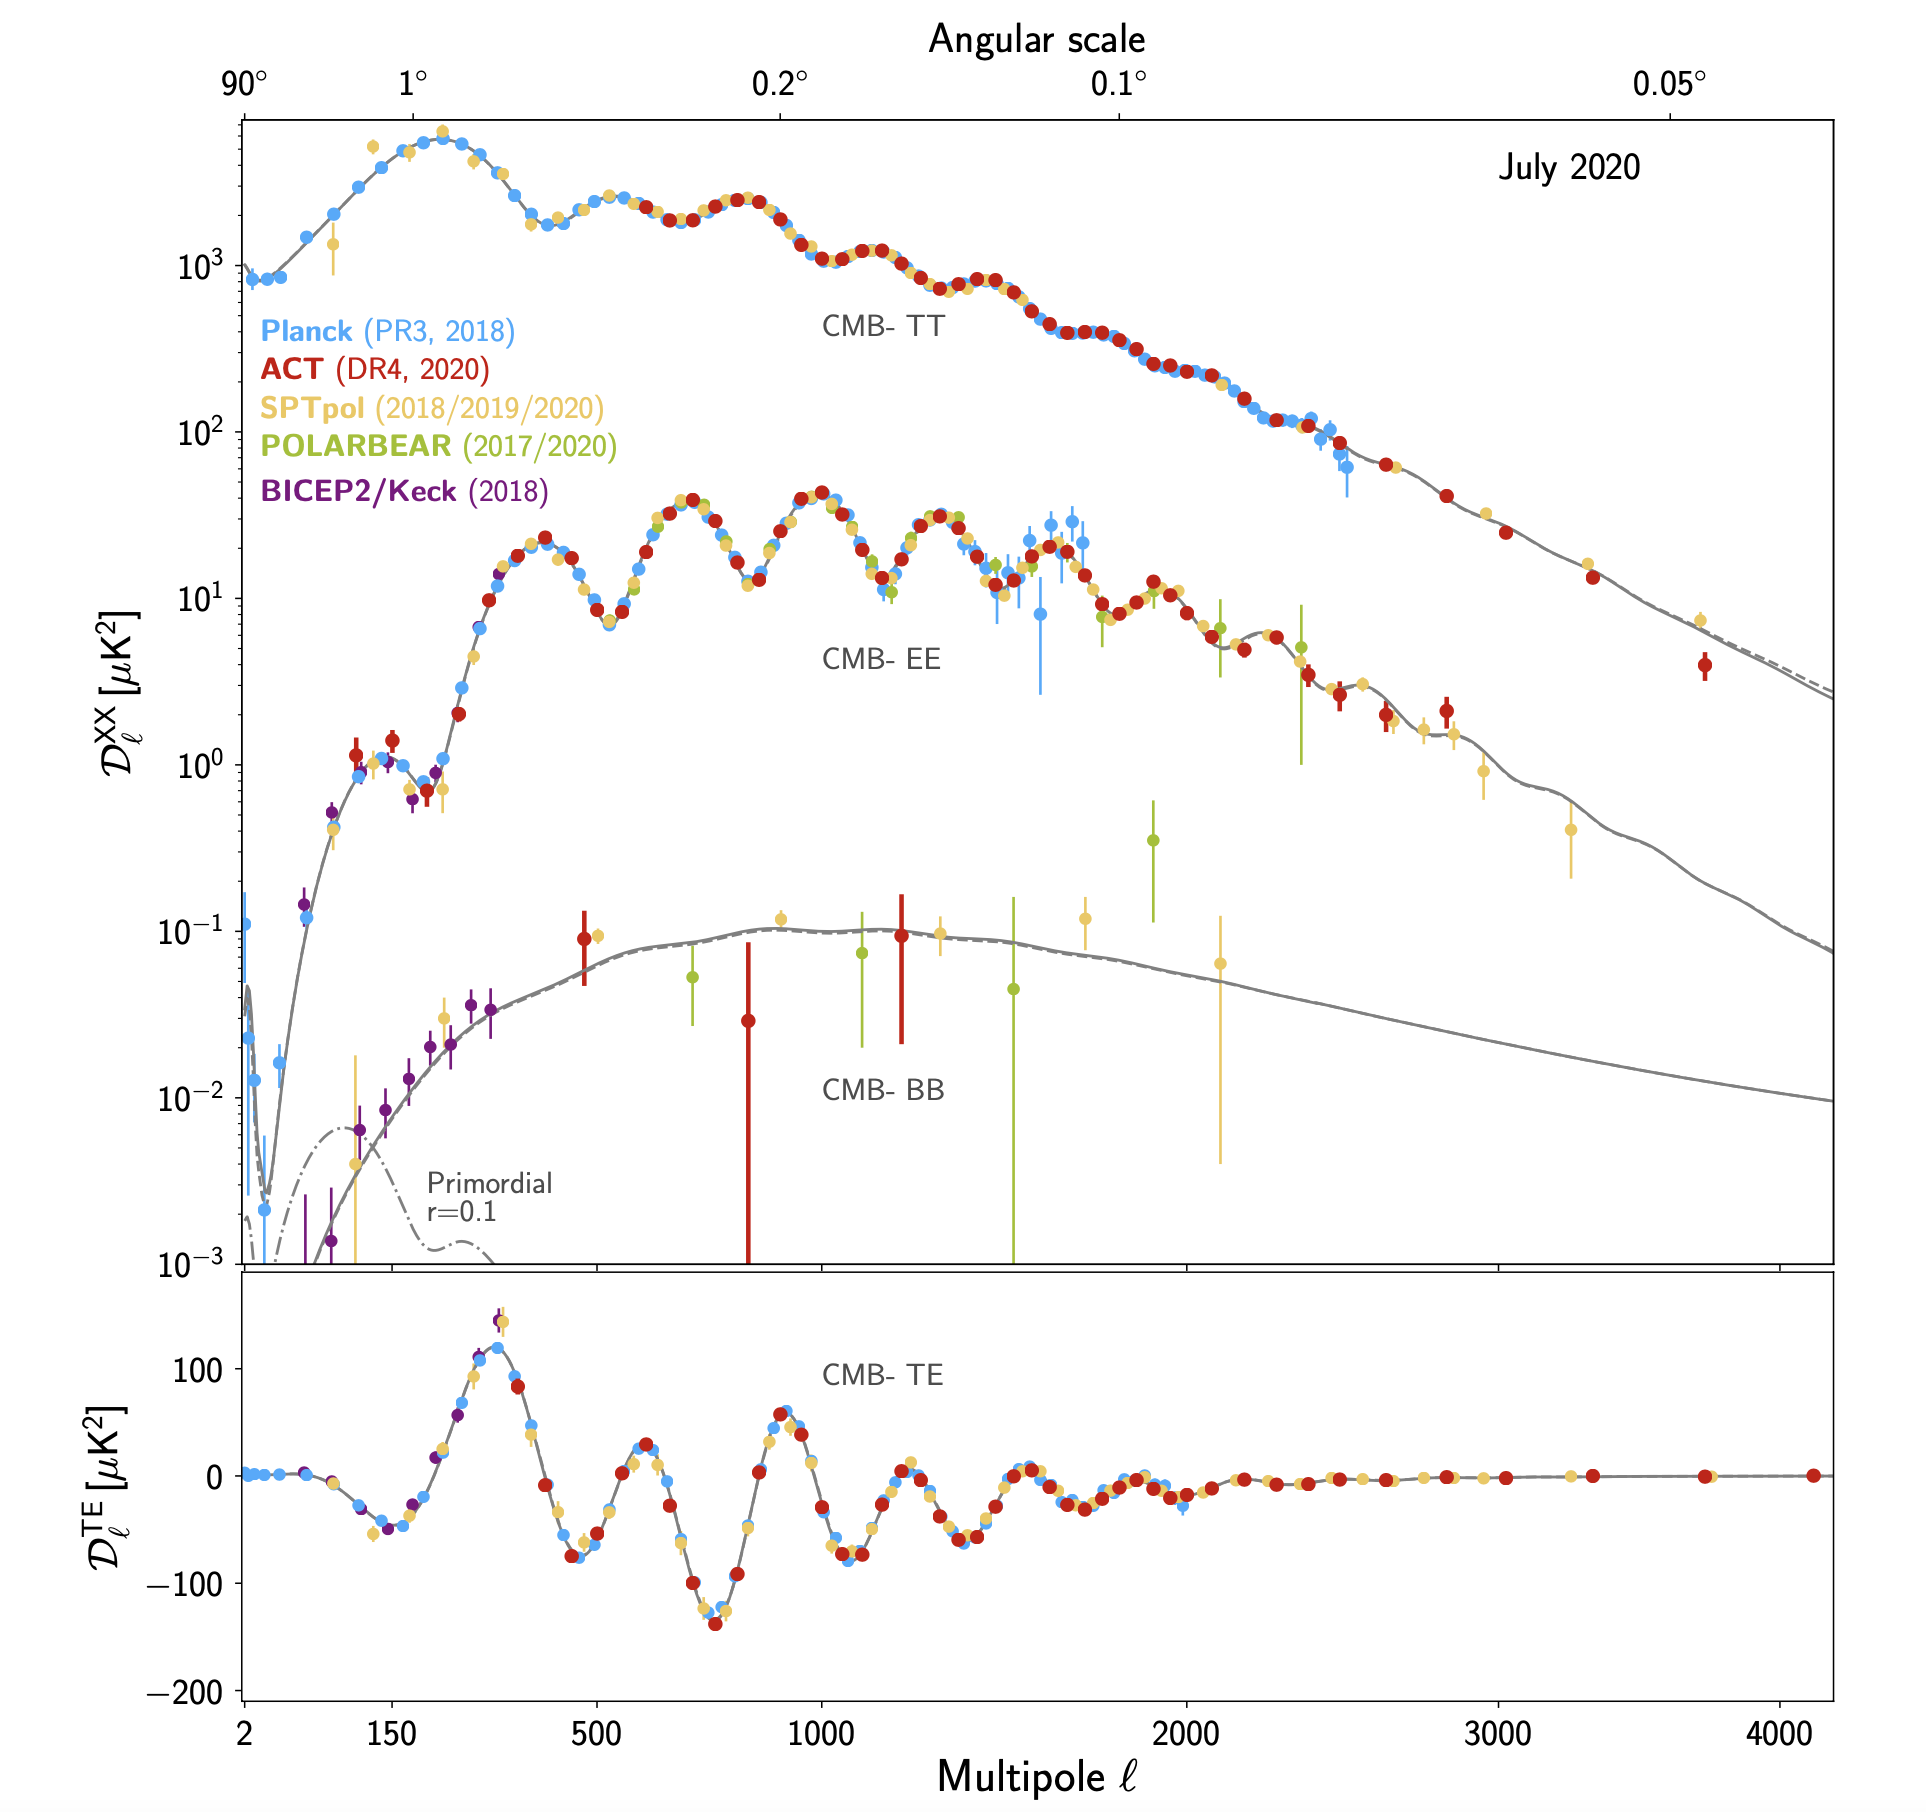
</div>
Source: Choi et al 2020

Blind methods assume that the spectral dependence of the primary signal is known perfectly. They then make minimal assumptions about the properties of the foregrounds to obtain the CMB component. In this tutuorial we will explore one of the simplest of such methods: the internal linear combination. It only makes the assumption that the foregrounds are uncorrelated from the CMB anisotropies. This then method linearly combines observations to obtain a CMB map that minimize the variance of this component. To obtain this solution the properties of the foregrounds are implicitly estimated from the empirical data. We will discuss the details of this more below. 


As always, each foreground separation method has it advantages and disadvantages and should be choosen to suit the specific probelm. 

# How can I make a quick simulation of Galactic foregrounds?

There are good simulation codes available, including PySM as noted below. But for now let's assume something more simplistic and only partly realistic. We'll assume there are just two components: synchrotron and dust with approximately the right frequencuy dependence, and semi-realistic angular dependence. We generate them with Gaussian realizations to have a spectrum that scales as Dl~l^0.7, but then add some non-Gaussian Galactic behaviour by taking the absolute value of this field, and adding a gradient (to mimic reduction of signal away from Galactic plane, for example). The estimated power-law scaling of the intensity in RJ units is frequency to the power -3 for synchrotron and 1.7 for dust (although dust is better modeled not as a power law but as a modified blackbody)

(Note, there are also other foregrounds in intensity, including free-free, anomalous microwave emission, CO line emission, which we are neglecting here for pedagogical reasons but would be there in full simulations)

In [ ]:
# read in the input CMB spectra
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)

#Approximate a foreground power spectrum at some reference frequency 
Dl_fg = 0.5e4*ell**-.7 
plt.plot(ell,DlTT)
plt.semilogy(ell,Dl_fg)
plt.ylabel(r'$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel(r'$\ell$')
plt.show()

In [ ]:
# make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
# compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
# in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
# compute the transpose for the y dimension
Y = np.transpose(X)

CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)
Fg1 = cmb_modules.make_CMB_T_map(N,pix_size,ell,Dl_fg)
Fg1 = np.abs(Fg1)+((0.5-Y)*50)   #dust - with arbitrary gradient term added

Fg2 = cmb_modules.make_CMB_T_map(N,pix_size,ell,Dl_fg)
Fg2 = np.abs(Fg2)+((0.5-Y)*50)   #synch - with arbitrary gradient term added

cmb_modules.Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)

cmb_modules.Plot_CMB_Map(Fg2,0,100,X_width,Y_width)


Now let's find out how the component maps should scale with frequency, by calculating the expected scaling of intensity compared to a reference frequency of 90 GHz in CMB temperature units. We can do this both in CMB temperature units (where a blackbody is flat in frequency), and also in RJ units. The power-law behavior is in RJ units.

In [ ]:
# frequency scaling

dust_exponent= 1.7
synch_exponent = -3.
reference_frequency = 90.  # in GHz

T_CMB = 2.72548
h = 6.62607015e-34
k = 1.380649e-23 
H_OVER_KT_CMB = h * 1e9 / k / T_CMB

bands = np.array([27.,37.,90.,145.,225.,280.])  ## in GHz

def dust_scaling(freq,dust_exponent,reference_frequency):
    dust_scaling = (freq / reference_frequency)** dust_exponent
    return(dust_scaling)

def synch_scaling(freq,synch_exponent,reference_frequency):
    synch_scaling = (freq / reference_frequency)** synch_exponent
    return(synch_scaling)

def rj2cmb(nu):
    x = H_OVER_KT_CMB * nu
    return (np.expm1(x) / x)**2 / np.exp(x)


print("bands: ", bands)
print("dust scaling (RJ): ",  dust_scaling(bands,dust_exponent,reference_frequency))
print("synchrotron scaling (RJ): ", synch_scaling(bands,synch_exponent,reference_frequency))
print("dust scaling (T_CMB): ", dust_scaling(bands,dust_exponent,reference_frequency)*rj2cmb(bands))
print("synchrotron scaling (T_CMB): ", synch_scaling(bands,synch_exponent,reference_frequency)*rj2cmb(bands))

Below you will find code that plots a map of the CMB and galactic foregrounds for a given band choice. The example for 90 GHz is given here. 

In [ ]:
band = 90.
dust_scale = dust_scaling(band,dust_exponent,reference_frequency)*rj2cmb(band)
synch_scale = synch_scaling(band,synch_exponent,reference_frequency)*rj2cmb(band)

Map_90GHz = CMB_T + Fg1*dust_scale +Fg2*synch_scale

cmb_modules.Plot_CMB_Map(Map_90GHz,c_min,c_max,X_width,Y_width)

## Exercise 1.  
Make plots of the sky (CMB + foregrounds) in different bands.  Qualitatively note how the foreground level changes with frequency.

In [ ]:
#Your code and plots go here.




Now let's look at the signal in the maps as a function of frequency. We can compute the rms for one of the maps as

In [ ]:
rms90 = np.sqrt(np.mean(Map_90GHz**2))
print('90 GHz rms = ', rms90, 'uK')

## Exercise 2

Now compute this for the other frequencies and compare the scaling of the total signal compared to the CMB. (ie. plot rms value vs freq!)

In [ ]:
#Your code goes here 

Note, the intensity foregrounds are not actually this large in the part of the sky we usually use for CMB analysis. There the CMB dominates at 90-150 GHz in intensity. This is just a more extreme example so we can more easily see the effects of cleaning foregrounds.

## Template subtraction

Now we can try out a very simple method for cleaning a map: define a template that traces the foreground, and remove a scaled version of the template from the map. Find the template coefficient, i.e. how much it should be scaled by, by minimizing the variance in the cleaned map. Here we will neglect the synchrotron and just try removing the dust from 150 GHz. We'll make a template from the difference of 280-220GHz, since then the CMB common to both will cancel.

In [ ]:
## create a dust template

dust_template =  (Map_280GHz-Map_220GHz)



## Exericise 3

Find the template coefficients that minimize variance in the map (this can be done crudely ~ by eye or more sophisticatedly as you prefer!) 

Plot the full sky, cleaned and true cmb sky

In [ ]:
#

# The Internal Linear Combination method (ILC)

We will apply ILC method in harmonic space to generate maps of E and B modes however this method can be applied in any basis (eg in real space or to Cls themselves) so in our discussion below we use a general notation.

We have an set of observations of the sky, $\hat{d}_{\nu_i}(\mathbf{n})$, at frequency, $\nu_i$, and spatial/harmonic index $\mathbf{n}$.

We are intersted in recovering the signal, $s(\mathbf{n})$ , which contributes to an observation at frequency each frequency by $a_{\nu_i}s(\mathbf{n})$. For this method we assume that we know exactly the spectral function  and so can compute $a_{\nu_i}$. For the CMB we do know this very accurately!! 



Given this signal model we can express our data vector as:

### $\hat{d}_{\nu_i}(\mathbf{n}) = a_{\nu_i}s(\mathbf{n}) + n_{\nu_i}$

where $ n_{\nu_i}$ is called the 'noise' at frequency $\nu_i$. This 'noise' is actually composed of everything that is not the signal of interest! For our case the noise will be composed of the experimental noise, the dust emission and the synchrotron emission.

The idea of the ILC is create a linear combination of these maps to recover the signal:

### $\hat{s}(\mathbf{n}) = \sum\limits_i w_i(\mathbf{n})\hat{d}_{\nu_i}(\mathbf{n})$.

(For clarity we surpress the \mathbf{n} index from here on )


We impose two conditions upon these weights:
- Firstly we want an unbiased measurement of the signal. Thus we impose:

### $\sum\limits_i w_i a_{\nu_i} = 1$.
- Secondly we want the lowest possible noise level in the resulting map. I.e.:

### $\frac{\partial}{\partial w_i} \langle \hat{s}(\mathbf{n}) \hat{s}(\mathbf{n}) \rangle =0 $

It is a straightforward exercies to show that the weights that satisfy these conditions are given by 

### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

where ${C^{-1}}^{\nu_i,\nu_j}$ is the channel to channel covariance matrix

Thus the solution for the CMB map is 

### $\hat{s}(\mathbf{n}) = \frac{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j}\hat{d}_{\nu_j} }{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}} $

A priori we do not always (or even often) know the frequency-frequency covariance matrix. To solve this we use the empirical covariance matrix!




In some cases we want to have a map which explicitly nulls a component on the sky. The ILC method can be extended to do this. See: https://arxiv.org/pdf/1911.05717.pdf

Limitations of the ILC method: 
- If you have an accurate parametric form for all the sky components that model can likely achieve a lower noise reconstruction.
- We assume that the component of interest has a unique spectral signature. If you have a second component with the same frequency response this will also be present in your final map. As a practical example: an ILC map from the primary temperature anisotropies would contain both CMB anisotropies and the kSZ signal.
- As the remaining noise is a combination of instrumental noise and residual foregrounds it is difficult to construct splits of the data with independent noise. Thus power spectra of the maps will always have a noise bias term that needs to be computed (often via simulations). 
- Caution needs to be taken if part of the 'noise' is correlated with the signal of interest

# Lets try it out!

Lets generate a set of idealized observations

In [ ]:
# For simplicity we made a simple python object that can be used to easily generate observations.
import foregrounds
simple_sky_model = foregrounds.simple_sky_model(seed=1)

### Lets generate some mock observations

In [ ]:
maps = {}
for freq in [30,90,120,150,220]:
    T_map      = simple_sky_model.observe(freq_GHz=freq,noise_ukarcmin=3.,beam_fwhm_arcmin=freq/150.*20.)
    maps[freq] = T_map

In [ ]:
# View the maps:

In [ ]:
# eshow(maps[220],downgrade=4)
# eshow(maps[30],downgrade=4)

## Note that these maps are now full sky maps in CAR pixellation

We can use the tools in the pixell library to analyze these maps! 

First lets import pixell

In [ ]:

from pixell import enmap,curvedsky,enplot,utils
import foregrounds
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")


## The following functions will be of use:

This function performs the spherical harmonic transform to the desired lmax
### curvedsky.map2alm( Your_map_as_an_enmap, lmax=desired_lmax)

This function performs the inverse spherical harmonic transform. The second input should be an enamp. The output will be written here. (This contains the geometry (sky area, pixel size etc) of your map!)
### curvedsky.alm2map( Your_Alms, an_enmap_map_to_contain_the_output)

This function can be used to multiply the alms by a fuction of ell (all ms at each ell are times by the same value). The second argument is either an array of the function values at ell=0,1 ... ell_max or a function f(\ell)
### curvedsky.almxflx(Your_Alms, array or function to apply to alms)

This function computes the Cls from the alms
### curvedsky.alm2cl(alm_0,alm_1) # Note alm_1 is only needed for cross correlations.

## Step 1)
Measure the alms and the auto and cross spectra

In [ ]:
### Your code here



# Step 2)

Construct the ILC! Compute at each $\ell$:
### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

Compute the weights separately for the E/B modes.
(Typically np.linalg.solve gives more stable inv. C applications than directly computing the covariance matrix.)

Use curvedsky.almxfl to apply the weights to the alms.

In [ ]:
### Your code here



# Step 3)

Compare to the ground truth (perhaps easiest to do at the power spectrum level).

In [ ]:
# alm_cmb_T = simple_sky_model.get_input_cmb_alms()

### Your code here


# Step 4)

Compute the cross power spectrum of the ILC map with the input dust and sync maps (use the two functions below for retrieving those!). Is this consistent with zero?



In [ ]:
# # These function can be used to get the sky dust and sync components

# alm_dust_T= simple_sky_model.get_input_dust_alms()

# alm_sync_T= simple_sky_model.get_input_sync_alms()

# Step 5)

Put your code in a loop. Generate a set of new maps (change the seed for the sky each time) and a new set of ILC maps. Does your method give an unbiased measurement of the sky?

In [ ]:

### Your code here

# Optional extension 1)
Did you find a bias? This is known as the ILC bias! 


This bias occurs due to our use of the empirical covariance matrix in the weights. This can be understood simply: the weights depend on the data, imagine we have a large upward fluctuation in the data, this will result in a large fluctation in the covariance and will result in that mode being excessively downweighted in the ILC solution (the covariance matrix depends on the data squared). Phrased more broadedly the covariance matrix has correlation with the data and so when we compute the expected value for the ILC solution we need to include these.


For a comprehensive discussion of this see the appendicies of https://arxiv.org/pdf/0807.0773.pdf

#### How can we avoid this?  
- The true covariance matrix! Unfortunately this is not generally available.
- Compute the covariance matrix from an independent set of modes.
- In our case we can make the approximatation the covariance of adjacent $\ell$ is same. Thus we can compute the covariance matrix at each ell using the spectra at $\ell+1$ and  $\ell-1$. 
- This approach can be difficult to implement in practice where different ells are correlated (e.g. do to masking) and as it rapidly becomes computationally very expensive.

#### How can we supress this? 
- We can use reduce these biases by averaging modes. 
- For our case we can do this simply. Instead of using the measured power spectrum at each ell $C_\ell$, we can average over a range of ells. This will reduced the correlation between the covariance matrix and the data.

## Try one of the above approaches. Does it supress the bias?

# Optional extension 2)

We can now try out this method on the polarized sky. This will require using the E/B methods we explored yesterday.

Lets first explore the sky in polarization.

### Task 1)

Observe the sky and create an empirical version Figure 1) for E and B mode polarization. 

I.E. Observed rms E /B mode vs frequency (or if you prefer C(ell=50) and C(ell=300) EE, BB vs freq).

In [ ]:
# To generate a sky use this class. The interface is the same, however the function returns two maps: Q and U.
simple_sky_model = foregrounds.simple_sky_model_pol(seed=1)
Q_map,U_map      = simple_sky_model.observe(freq_GHz=freq,noise_ukarcmin=3.,beam_fwhm_arcmin=freq/150.*20.)

In [ ]:
### Your code goes here

We actually know that the polarized sky is slightly simpler than the temperature case. At the frequenies of interest there are just three non-negligible components: dust, synchrotron and the CMB.

Lets make a quick estimate of the relevance of each of the components. 

For this part we can also increase the realism of the component frequency spectra:

The synchroton spectral energy distribution is modelled as a power law in frequency, as before.

The dust SED is modelled as a grey body:
$I(\nu) = \nu^\beta B_\nu(T_d)$ where $\beta$ is the dust  spectral index that is observed to be $\sim 1.4$ and T$_d$ is the dust temperature that is $\sim 15$K.

One slight complication. The dust SED are measures of flux and so are in Janksys per steradian whereas we normally think in terms of temperature units for the CMB anisotropies (frequently $\delta T/T$ or $\mu$K or nK). To plot the three components you should standardize the units. (If you need some ideas on how to do this perhaps have a look around eq.5 and eq.6 here: https://arxiv.org/pdf/1303.5087.pdf)

In [ ]:
from foregrounds import synchrotron_SED,galaticDust_SED
# Example usage
print(synchrotron_SED(freq_GHz=30))
print(galaticDust_SED(freq_GHz=150))

### Step 2)

Now we lets reapply the ILC to these maps.

First observe the sky at a range of frequencies.

Second convert from Q/U to E/B

Third measure the auto and cross power spectra (are there any E cross B power spectra? )

Next compute the ILC weights (it is best done separately for E/B)

Finally apply your weights and compare the maps and power spectra!

# Optional extension 3)

The model of the galaxy used here is overly simplistic! 

Lets repeat this exercise with a more accurate model. We can use the excelent pysm library for this purpose. 

The installation instructions for this library are available here: https://pysm3.readthedocs.io/en/latest/#installation

However, one of these commands should work for you too:

pip install pysm3

conda install -c conda-forge pysm3


The library can be straightforwardly used with a few lines of code:




In [ ]:
# Import the library and the units module for convienience:
import pysm3;
import pysm3.units as u

With the library imported we initalized the sky class.
- nside sets the resolution of the maps, 
- preset_strings defines the models used for the sky. In this case we the models 'd1' for dust 1 and "s1" for synchroton model one. More information on the available models can be found on : https://pysm3.readthedocs.io/en/latest/  . The more accurate models allow use to test how well our foreground cleaning methods work when, for example, the dust spectral index varries across the map


Note when using this for the first time it will require an internet connection as it will download a set of template maps. This will generate a set of warnings.

In [ ]:
# Initalize the sky object

sky = pysm3.Sky(nside=512,preset_strings=["d1","s1"],output_unit="K_CMB")
# Get the map at the desired frequency:
I,Q,U = sky.get_emission(150*u.GHz)

In [ ]:
hp.mollview(Q)
hp.mollview(U)

For ease we have included a simple wrapper of this in a format identical to our simple model

In [ ]:
pysm_sky_model = foregrounds.pysm_sky_model(seed=1)
pysm_sky_model.observe(freq_GHz=150,noise_ukarcmin=1.,beam_fwhm_arcmin=8.)

## Apply the ILC to these more realistic maps

Can you obtain lower noise E/B maps through masking? 

You can download the planck galaxy mask with this link:

http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits


We can read the sky mask using the following command:
### hp.read_map(fileNameHere,field=index)

index is used to select the desired sky fraction as follows:

0: 20%, 1: 40%, 2: 60%, 3: 70%, 4: 80%, 5: 90%, 6: 97%, 7: 99%

# Optional extension 4)

 As discussed above the ILC method can be altered to 'deproject' sky components such that the ILC map not only minimizes the variance on the desired signal but also has zero contribution from a specific component. This is useful if, for example, you want to be sure your CMB map has not contribution from the SZ effect. The cost of this is an increase in the variance in the ILC map.
 
 
This method requires that we accurately know the signal of interests frequency function. Unfortunately this means that it can be used only to reduce residual dust and CIB contributions - not completely remove them! 

## Step 1)

First we need to modify the ILC equation. Recall that to derive the ILC equation we sought a solution that has unit response to the desired signal with minimum variance. To obtain the weights we minize the variance in the presences of a Lagrange multiplier to ensure unit reponse. Now we can simply add an additional constraint. 

First deduce the constraint and then recompute the ILC weights. 

You should find that your solution agrees with eq. 18 in https://arxiv.org/pdf/1006.5599.pdf

# Step 2)

Rerun your code from above using the modified weights. Deproject the dust contribution using the spectral functions from the first section.